In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial.distance import euclidean
plt.rcParams['figure.figsize'] = [10, 5]

# For results repeatability
np.random.seed(0)

# Dataset preprocessing

## Dataset 1

A function to upload and preprocess data in the "adults" format.

In [12]:
def get_clean_dataset1(data_file):
    dataset = pd.read_csv("data/adult.data", header=None)
    dataset.columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","salary"]
    dataset = dataset[(dataset!=" ?").all(axis=1)].reset_index(drop=True)
    df_strings = dataset.select_dtypes(['object'])
    dataset[df_strings.columns] = df_strings.apply(lambda x: x.str.strip())
    clean_dataset = pd.DataFrame(dataset["age"])
    for col in dataset.columns[1:-1]:
        if(dataset[col].dtype =='O'):
            clean_dataset = clean_dataset.join(pd.get_dummies(dataset[col], prefix=col))
        else:
            clean_dataset = clean_dataset.join(dataset[col])
    labels = (dataset["salary"]==">50K")*1
    dataset = clean_dataset
    return dataset, labels

### Training / Validation dataset

In [13]:
dataset, labels = get_clean_dataset1("data/adult.data")

### Test dataset

In [4]:
test_dataset = get_clean_dataset1("data/adult.test")

## Dataset 2

### Training / Validation dataset

### Test dataset

# Utils

In [5]:
def plotMeanAndStd(stats, x, color='b', ax = None, legend=None):
    """
    Input : array of tuples (mean std) and their x coordinates
    """
    mean = np.array([s[0] for s in stats])
    standard_dev = np.array([s[1] for s in stats])
    if ax == None :
        plt.plot(x, mean, c=color,label=legend)
        plt.fill_between(x, mean-standard_dev, mean+standard_dev, alpha=0.2, color=color)
    else:
        ax.plot(x, mean, c=color,label=legend)
        ax.fill_between(x, mean-standard_dev, mean+standard_dev, alpha=0.2, color=color)  

In [6]:
def error(predicted_labels, real_labels, loss="euclidean"):
    """
    Input: numpy array containing respectively the labels an algorithm predicted, and the real labels corresponding
    to the data. Type of loss we want to use.
    
    Output: float, the computed loss.
    """
    if loss == "euclidean": return euclidean(predicted_labels, real_labels)
    elif loss == "manhattan": return sum(abs(predicted_labels - real_labels))
    
    

# Cross validation

In [7]:
def cross_validation(algo, dataset_, labels_, loss_="manhattan", folds = 5, algo_kwargs={}):
    """
    Input : Predictor function that works by supplying training set and labels and test set and return predicted labels
            dataset  and corresponding labels
            folds
            algo_kwargs : a dict with additional params for the algo : ex. {'n_neighbors':5}
    Output : Precision mean and variance
    """
    dataset_size = dataset_.shape[0]
    group_ids = np.tile(np.arange(folds),int(dataset_size/folds)+1)[:dataset_size]
    np.random.shuffle(group_ids)
    training_precisions = []
    validation_precisions = []
    for N in range(folds):
        training_set = dataset_[group_ids != N]
        training_labels = labels_[group_ids != N]
        test_set = dataset_[group_ids == N]
        test_labels = labels_[group_ids == N]
        # Training error
        training_predicted_labels = algo(training_set, training_labels, training_set, **algo_kwargs)
        training_precisions += [(len(training_labels) - error(training_predicted_labels, training_labels, loss = loss_))/len(training_labels)]
    
        
        # Validation error
        validation_predicted_labels = algo(training_set, training_labels, test_set, **algo_kwargs)
        validation_precisions += [(len(test_labels) - error(validation_predicted_labels, test_labels, loss = loss_))/len(test_labels)]
    
    
    return (np.mean(training_precisions), np.std(training_precisions), np.mean(validation_precisions), np.std(validation_precisions))

In [15]:
def data_size_influence(algo, dataset_, labels_, N_start, N_end, N_step, loss_="manhattan", folds = 5, algo_kwargs={}, show_time=False, visualize=True):
    
    nrows = dataset_.shape[0]
    Ns = []
    mean_trainings = []
    std_trainings = []
    mean_validations = []
    std_validations = []
    
    if show_time: times = []
    
    for N in range(N_start, N_end, N_step):
        Ns.append(N)
        indices = list(np.random.choice(nrows, N))
        d = dataset.iloc[indices]
        l = labels.iloc[indices]
        
        if show_time: t = time.time()
        mean_training, std_training, mean_validation, std_validation = cross_validation(knn, d, l, folds = folds, algo_kwargs=algo_kwargs)
        if show_time: times.append(time.time() - t)
        
        mean_trainings.append(mean_training)
        std_trainings.append(std_training)
        mean_validations.append(mean_validation)
        std_validations.append(std_validation)
    
    if visualize:
        fig = plt.figure(figsize=(10,7))
        fig.suptitle("Influence of training/validation dataset size")
        ax1 = fig.gca()
        plotMeanAndStd([i for i in zip(mean_trainings, std_trainings)],Ns, ax= ax1, legend = "Training", color='red')
        plotMeanAndStd([i for i in zip(mean_validations, std_validations)],Ns, ax= ax1, legend = "Validation",color='blue')
        ax1.legend(loc="lower right")
        ax1.set_ylabel("Precision")
        ax1.set_xlabel("Dataset sample size")
        ax1.grid()

        if show_time:
            ax5 = ax1.twinx()
            ax5.set_ylabel("Computation time (s)")
            ax5.plot(Ns, times, label ="Computation time", c="orange")

        fig.tight_layout()
        plt.show()
    
    if show_time: return (mean_trainings, std_trainings, mean_validations, std_validations, times)
    else: return (mean_trainings, std_trainings, mean_validations, std_validations)

# Knn

We use scikit-learn's knn function to design a knn classifier.

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
def knn(training_features, training_labels, to_predict_features,
        n_neighbors=5, weights = "uniform", algorithm="auto", p=2):
    
    """
    Input: Training data, features for which we want to predict the labels, number of neighbors k for knn algo,
    features weights system (uniform or distance), algorithm usewd to find closer k neighbors, p is the value
    used in the computation of the minkowski distance that is used here, p=1 gives a manhattan distance, p=2 a
    euclidian distance.
    
    Output: Numpy array containing the labels predicted by KNN for the given 'to_predict_features'
    """
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, p=p)
    neigh.fit(training_features, training_labels)
    
    return neigh.predict(to_predict_features)

Let us study the influence of the hyperparameter k (number of neighbors) on KNN algorithm's performance.

In [16]:
def n_neighbors_influence_multiple_datasize(Ks, dataset_, labels_, N_start, N_end, N_step, loss_="manhattan",
                                            folds = 5, show_time=False, visualize=True):
    
    mean_training_per_k = dict()
    std_training_per_k = dict()
    mean_validation_per_k = dict()
    std_validation_per_k = dict()
    
    if show_time: time_per_k = dict()
    
    for k in Ks:
        print(k)
        if show_time: (mean_trainings, std_trainings, mean_validations, std_validations, times) = data_size_influence(knn, dataset_, labels_, N_start, N_end, N_step, loss_="manhattan", folds = folds, algo_kwargs={"n_neighbors":k}, show_time=show_time, visualize=False)
        else: (mean_trainings, std_trainings, mean_validations, std_validations) = data_size_influence(knn, dataset_, labels_, N_start, N_end, N_step, loss_="manhattan", folds = folds, algo_kwargs={"n_neighbors":k}, show_time=show_time, visualize=False)
            
        mean_training_per_k[k] = mean_trainings
        std_training_per_k[k] = std_trainings
        mean_validation_per_k[k]  = mean_validations
        std_validation_per_k[k]  = std_validations

        if show_time: time_per_k[k]  = times
    
    if visualize:
        
        Ns = list(range(N_start, N_end, N_step))
        
        fig = plt.figure(figsize=(10,7))
        fig.suptitle("Influence of K (in k nearest neighbor) and training/validation dataset size")
        
        ax1 = fig.add_subplot(231)
        ax1.title.set_text("Mean training precision")
        for k in Ks:
            ax1.plot(Ns, mean_training_per_k[k], label=f"k={k}")
        plt.legend()

        ax2 = fig.add_subplot(232)
        ax2.title.set_text("Training precision's standard deviation")
        for k in Ks:
            ax2.plot(Ns, std_training_per_k[k], label=f"k={k}")
        plt.legend()

        ax3 = fig.add_subplot(233)
        ax3.title.set_text("Mean validation precision")
        for k in Ks:
            ax3.plot(Ns, mean_validation_per_k[k], label=f"k={k}")
        plt.legend()

        ax4 = fig.add_subplot(234)
        ax4.title.set_text("Validation precision's standard deviation")
        for k in Ks:
            ax4.plot(Ns, std_validation_per_k[k], label=f"k={k}")
        plt.legend()

        if show_time:
            ax5 = fig.add_subplot(235)
            ax5.title.set_text("Computation time")
            for k in Ks:
                ax5.plot(Ns, time_per_k[k], label=f"k={k}")
            plt.legend()
        
        
        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=3, 
                        top=3, 
                        wspace=1, 
                        hspace=1)

        fig.tight_layout()
        
        plt.show()
        
        
    
    
    if show_time: return (mean_training_per_k, std_training_per_k, mean_validation_per_k, std_validation_per_k, time_per_k)
    else: return (mean_training_per_k, std_training_per_k, mean_validation_per_k, std_validation_per_k)
    

1
2


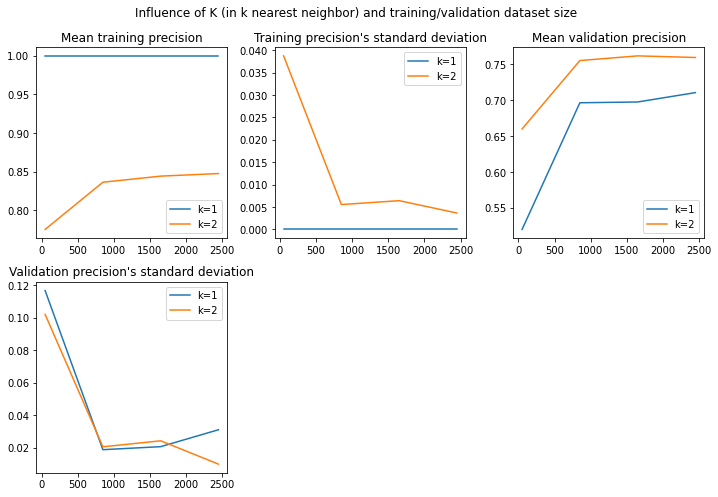

({1: [1.0, 1.0, 1.0, 1.0],
  2: [0.775, 0.8361764705882353, 0.844090909090909, 0.8474489795918367]},
 {1: [0.0, 0.0, 0.0, 0.0],
  2: [0.03872983346207416,
   0.005549400665915629,
   0.0064175207831961845,
   0.0036649561216465405]},
 {1: [0.52, 0.6964705882352942, 0.6975757575757576, 0.7106122448979593],
  2: [0.6599999999999999,
   0.7552941176470588,
   0.7618181818181818,
   0.759591836734694]},
 {1: [0.11661903789690597,
   0.018823529411764687,
   0.020677238920281216,
   0.031068705688138878],
  2: [0.10198039027185571,
   0.020579830217101056,
   0.024287836253956228,
   0.009947802128125656]})

In [18]:
n_neighbors_influence_multiple_datasize(list(range(1, 3)), dataset, labels, 50, 3000, 800, loss_="manhattan",
                          folds = 5, show_time=False, visualize=True)
pass

In [ ]:
def n_neighbors_influence_fixed_datasize(Ks, dataset_, labels_, N, loss_="manhattan",
                                         folds = 5, show_time=False, visualize=True):
    nrows = dataset_.shape[0]
    mean_trainings = []
    std_trainings = []
    mean_validations = []
    std_validations = []
    
    if show_time: times = []
    
    for k in Ks:
        indices = list(np.random.choice(nrows, N))
        d = dataset.iloc[indices]
        l = labels.iloc[indices]
        
        if show_time: t = time.time()
        mean_training, std_training, mean_validation, std_validation = cross_validation(knn, d, l, folds = folds, algo_kwargs={"n_neighbors": k})
        if show_time: times.append(time.time() - t)
        
        mean_trainings.append(mean_training)
        std_trainings.append(std_training)
        mean_validations.append(mean_validation)
        std_validations.append(std_validation)
    
    if visualize:
        fig = plt.figure(figsize=(10,7))
        fig.suptitle("Influence of training/validation dataset size")
        ax1 = fig.add_subplot(231)
        ax1.title.set_text("Mean training precision")
        ax1.plot(Ks, mean_trainings)

        ax2 = fig.add_subplot(232)
        ax2.title.set_text("Training precision's standard deviation")
        ax2.plot(Ks, std_trainings)

        ax3 = fig.add_subplot(233)
        ax3.title.set_text("Mean validation precision")
        ax3.plot(Ks, mean_validations)

        ax4 = fig.add_subplot(234)
        ax4.title.set_text("Validation precision's standard deviation")
        ax4.plot(Ks, std_validations)

        if show_time:
            ax5 = fig.add_subplot(235)
            ax5.title.set_text("Computation time")
            ax5.plot(Ks, times)
        
        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=3, 
                        top=3, 
                        wspace=1, 
                        hspace=1)

        fig.tight_layout()
        plt.show()
    
    if show_time: return (mean_trainings, std_trainings, mean_validations, std_validations, times)
    else: 
        return (mean_trainings, std_trainings, mean_validations, std_validations)
    

In [ ]:
 n_neighbors_influence_fixed_datasize(list(range(1, 100)), dataset, labels, 2000, loss_="manhattan",
                                         folds = 5, show_time=False, visualize=True)

### Knn results for dataset 1

##### Selecting best hyperparameter

In [ ]:
# TO DO : plot the performance depending on K for the entire dataset, choose simplest best K

##### Results on test dataset

In [ ]:
# TO DO : print precision of test dataset, add confusion matrix

### Knn results for dataset 2

##### Selecting best hyperparameter

In [ ]:
# TO DO : plot the performance depending on K for the entire dataset, choose simplest best K

##### Results on test dataset

In [ ]:
# TO DO : print precision of test dataset, add confusion matrix

# Decision tree

We use scikit-learn's decision tree function to design a decision tree classifier.

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

In [ ]:
def decision_tree(training_features, training_labels, to_predict_features,
                  criterion='gini', splitter='best'):
    """
    :param training_features: training features (x)
    :param training_labels: training labels (y)
    :param to_predict_features: features that we want to predict
    :param criterion: {"best", "random"} Default is "gini" for the Gini impurity and "entropy" for the information gain
    :param splitter: {"best", "random"} Default is "best" to choose the best split and "random" to choose the best random split.
    :return:Numpy array containing the labels predicted by Decision Tree for the given 'to_predict_features'
    """
    classifier = DecisionTreeClassifier(criterion=criterion, splitter=splitter)
    classifier.fit(training_features, training_labels)
    
    return classifier.predict(to_predict_features)

In [ ]:
# TO DO : see influence of cost function on precision (same graph as for KNN : dataset size on x axis, one trace for each cost function)

In [ ]:
# TO DO : see influence of max depth on precision (same graph as for KNN : fixed data set size, max depth on x axis, precision on y)

### Decision tree results for dataset 1

##### Selecting best hyperparameter

In [ ]:
#TO DO plot precision depending on max depth, one line for each cost function, selecting simplest best model

##### Results on dataset 1

In [ ]:
# Print precision and confusion matrix on test dataset

### Decision tree results for dataset 2

##### Selecting best hyperparameter

In [ ]:
#TO DO plot precision depending on max depth, one line for each cost function, selecting simplest best model

#### Results on dataset 2

In [ ]:
# Print precision and confusion matrix on test dataset

# Influence of dataset's size

Now we study the influence of the size of the training / validation dataset on the training / validation errors.

In [ ]:
data_size_influence(knn, dataset, labels, 50, 10000, 1000, loss_="manhattan", folds = 5, algo_kwargs={"n_neighbors":3}, show_time=True, visualize=True)
pass